In [10]:
# pip install ipympl mpl-interactions
# pip install ipympl mpl-interactions
#https://github.com/lyeoni/pytorch-mnist-VAE
#https://github.com/sssingh/mnist-digit-generation-gan/blob/master/mnist_gan.ipynb
# prerequisites
import torch
th = torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels
    
class ArrayToDataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        data = data.reshape((-1,)+(int(X_train.shape[-1]**0.5),)*2)
        self.data = torch.tensor(data/256.0)
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx].unsqueeze(0).to(th.float32)
        label = -1
        if self.targets is not None:
            label = self.targets[idx]
        
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load Dataset

In [28]:
dataset_name = 'fashion'
bs = 100
if dataset_name == 'fashion':
    X_train, y_train = load_mnist('../../../Datasets/fashion', kind='train')
    X_test, y_test = load_mnist('../../../Datasets/fashion', kind='t10k')
    train_dataset = ArrayToDataset(X_train, y_train)
    test_dataset = ArrayToDataset(X_test, y_test)
if dataset_name == 'mnist':
    test_dataset = datasets.MNIST(root='../../../Datasets/', train=False, transform=transforms.ToTensor(), download=False)
    train_dataset = datasets.MNIST(root='../../../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
if dataset_name == 'mnist':
    # import from folder -> images (array) [Number of images x H x w x 3] 
    train_dataset = ArrayToDataset(X_train, y_train)
    test_dataset = ArrayToDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

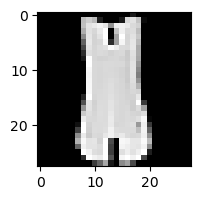

In [12]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(2,2))
plt.imshow(train_dataset[4][0].numpy().reshape(28,28), cmap='gray')
plt.show()

# Build Model Parts

## Main Model Architecture

In [14]:
# this creates the model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
z_dim=2
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [15]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

## Loss Function

In [7]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

## Training Function

In [8]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        #data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Evaluation Function

In [9]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            #data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Training Process

In [10]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.509453
Train Epoch: 1 [10000/60000 (17%)]	Loss: 291.070273
Train Epoch: 1 [20000/60000 (33%)]	Loss: 285.167578
Train Epoch: 1 [30000/60000 (50%)]	Loss: 274.091387
Train Epoch: 1 [40000/60000 (67%)]	Loss: 284.030117
Train Epoch: 1 [50000/60000 (83%)]	Loss: 270.721074
====> Epoch: 1 Average loss: 285.3659
====> Test set loss: 270.1969
Train Epoch: 2 [0/60000 (0%)]	Loss: 268.188379
Train Epoch: 2 [10000/60000 (17%)]	Loss: 264.353066
Train Epoch: 2 [20000/60000 (33%)]	Loss: 264.344082
Train Epoch: 2 [30000/60000 (50%)]	Loss: 270.175137
Train Epoch: 2 [40000/60000 (67%)]	Loss: 264.184785
Train Epoch: 2 [50000/60000 (83%)]	Loss: 273.867344
====> Epoch: 2 Average loss: 266.5632
====> Test set loss: 266.3108
Train Epoch: 3 [0/60000 (0%)]	Loss: 257.674043
Train Epoch: 3 [10000/60000 (17%)]	Loss: 267.246328
Train Epoch: 3 [20000/60000 (33%)]	Loss: 261.205625
Train Epoch: 3 [30000/60000 (50%)]	Loss: 266.198945


KeyboardInterrupt: 

In [138]:
#torch.save(vae.state_dict(), 'models/vae_{}.p'.format(dataset_name))

In [16]:
vae.load_state_dict(torch.load('models/vae_{}.p'.format(dataset_name)))

<All keys matched successfully>

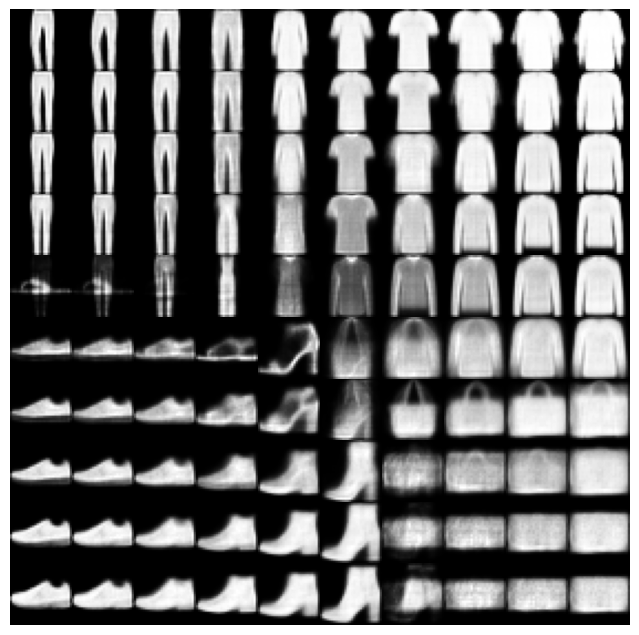

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th

# Define the grid in the latent space
grid_size = 10
z_range = np.linspace(-2, 2, grid_size)
latent_grid = np.array(np.meshgrid(*(z_range,)*z_dim)).T.reshape(-1, z_dim)
latent_grid[:,2:]=0.

# Generate MNIST images for each point in the grid
generated_images = vae.decoder(th.tensor(latent_grid).to(th.float)).detach().numpy()

# Create a grid of subplots to display the images
fig, axs = plt.subplots(grid_size, grid_size, figsize=(8, 8))
for i in range(grid_size):
    for j in range(grid_size):
        ax = axs[i, j]
        ax.imshow(generated_images[i * grid_size + j].reshape(28, 28), cmap='gray')
        ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

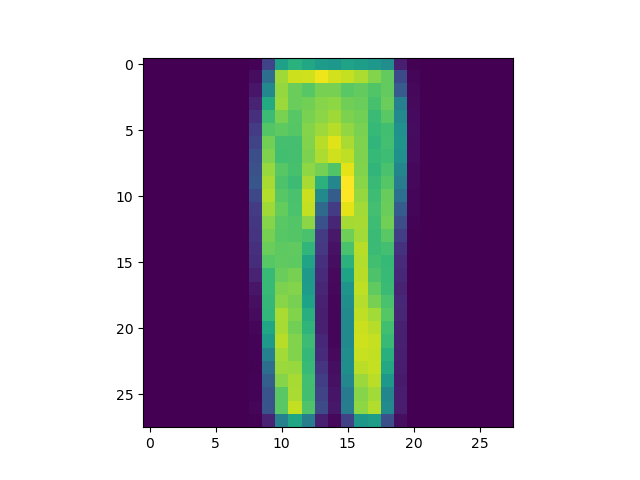

In [18]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

from mpl_interactions import ipyplot as iplt

def f(param1, param2):
    z = torch.tensor([param1,param2]).reshape(1,2).to(torch.float)
    sample = vae.decoder(z).detach()[0].reshape(28,28)
    return sample


fig, ax = plt.subplots()
controls = iplt.imshow(f, param1=(-1, 1), param2=(-1, 1))

### Ignore below

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

In [6]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

In [7]:
# Training loop function
import pickle as pkl

def train_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    z_size = dim_init
    
    fixed_z = np.random.uniform(-1, 1, size=(16, dim_init))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = (real_images * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

In [11]:
##
## Prepare and start training
##
dim_init = 2
# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=dim_init, out_features=784)

In [12]:

#g = Generator(100, 32, 784)
print(d)
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_gan(d, g, d_optim, g_optim, 
                               loss_fn, train_loader, n_epochs, device,
                               verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/100]:


KeyboardInterrupt: 

In [13]:
# torch.save(d.state_dict(), 'models/gan_d_{}.p'.format(dataset_name))
# torch.save(g.state_dict(), 'models/gan_g_{}.p'.format(dataset_name))
d.load_state_dict(torch.load('models/gan_d_{}.p'.format(dataset_name)))
g.load_state_dict(torch.load('models/gan_g_{}.p'.format(dataset_name)))

<All keys matched successfully>

In [16]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------
import math
def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

In [15]:
show_generated_images(epoch=100, n_cols=8)

FileNotFoundError: [Errno 2] No such file or directory: 'fixed_samples.pkl'

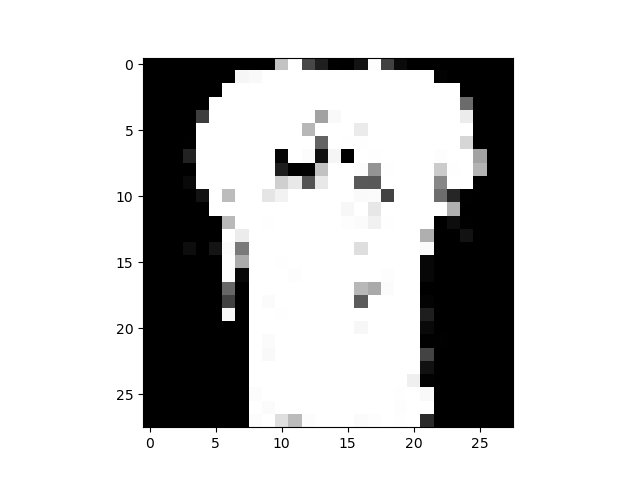

In [17]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

from mpl_interactions import ipyplot as iplt

def f(param1, param2):
    z = torch.tensor([param1,param2]).reshape(1,2).to(torch.float)
    sample = g(z).detach()[0].reshape(28,28)
    return sample

fig, ax = plt.subplots()
controls = iplt.imshow(f, param1=(-1, 1), param2=(-1, 1), cmap='binary_r')